# Cambodia Cube - Water Analysis Notebook 

**Description:** This Python notebook allows users to directly interact with a Cambodia Cube to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. 

The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.
****
Ensure:
- Cambodia Cube ('cambodia.conf') is saved and configured. 
- 'module load dea-env'
*****
This notebook is based on a CEOS notebook https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb 

The water classifier is based on Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." Remote Sensing of Environment. https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py



## Import libraries

In [41]:
# %matplotlib inline
%pylab notebook

from matplotlib import pyplot as plt
import ipywidgets as widgets

from datetime import datetime
import numpy as np
import gc
import warnings

import datacube
from datacube.storage import masking
import xarray as xr

import pandas as pd
from skimage import exposure
import matplotlib
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import calendar
import geopandas as gpd
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Link to Cambodia Cube

In [2]:
from datacube import Datacube
dc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf')

In [3]:
dc.list_measurements()

aliases  \
product                      measurement                                              
alos_fnf_mosaic              SAR_fnf                                            NaN   
alos_sar_mosaic              hh                                                 NaN   
                             hv                                                 NaN   
dem_3sec_hydrosheds          elevation                                          NaN   
ls5_usgs_sr_scene            blue                                [band_1, sr_band1]   
                             green                               [band_2, sr_band2]   
                             red                                 [band_3, sr_band3]   
                             nir                                 [band_4, sr_band4]   
                             swir1                               [band_5, sr_band5]   
                             swir2                               [band_7, sr_band7]   
                             pixel_qa                                    [pixel_qa]   
ls7_usgs_sr_scene            blue                                [band_1, sr_band1]   
                             green                               [band_2, sr_band2]   
                             red                                 [band_3, sr_band3]   
                             nir                                 [band_4, sr_band4]   
                             swir1                               [band_5, sr_band5]   
                             swir2                               [band_7, sr_band7]   
                             sr_atmos_opacity                            [atmos_op]   
                             pixel_qa                                    [pixel_qa]   
                             radsat_qa                                  [radsat_qa]   
                             sr_cloud_qa                                 [cloud_qa]   
ls8_usgs_sr_scene            coastal_aerosol                     [band_1, sr_band1]   
                             blue                                [band_2, sr_band2]   
                             green                               [band_3, sr_band3]   
                             red                                 [band_4, sr_band4]   
                             nir                                 [band_5, sr_band5]   
                             swir1                               [band_6, sr_band6]   
                             swir2                               [band_7, sr_band7]   
                             pixel_qa                                    [pixel_qa]   
                             sr_aerosol        [sr_aerosol_qa, aerosol_qa, aerosol]   
                             radsat_qa                                  [radsat_qa]   
ls_level2_geomedian_annual   blue                                [band_2, sr_band2]   
                             green                               [band_3, sr_band3]   
                             red                                 [band_4, sr_band4]   
                             nir                                 [band_5, sr_band5]   
                             swir1                               [band_6, sr_band6]   
                             swir2                               [band_7, sr_band7]   
pet_grids_1979_2016          PET                                                NaN   
rainfall_grids_1998_2017     rainfall                                           NaN   
spei_monthly_grids_1998_2017 spei_gamma_03                                      NaN   
                             spei_gamma_06                                      NaN   
                             spei_gamma_12                                      NaN   
temperature_grids_1979_2016  temperature                                        NaN   
wofs_grids_1987_2017         wofs                                               NaN   

                                                 dtype  \
product        

In [4]:
# def nan_to_num(dataset, number):
#     for key in list(dataset.data_vars):
#         dataset[key].values[np.isnan(dataset[key].values)] = number
        
def water_classifier(dataset_in):
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)

    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Water classifier. Regression analysis based on Australia training data.
        """

        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)

        #classified = np.ones(shape, dtype='uint8')

        classified = np.full(shape, no_data, dtype='uint8')

        # Start with the tree's left branch, finishing nodes as needed

        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0  #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1  #Node 6
        classified[_tmp2 & ~r4] = 0  #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1  #Node 10
        classified[_tmp2 & ~r6] = 0  #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1  #Node 14
        classified[_tmp2 & ~r8] = 0  #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1  #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1  #Node 19
        classified[_tmp & ~r10] = 0  #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()

        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0  #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0  #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1  #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1  #Node 31
        classified[_tmp2 & ~r16] = 0  #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1  #Node 33
        classified[_tmp2] = 0  #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0  #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0  #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0  #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0  #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1  #Node 44
        classified[_tmp & ~r22] = 0  #Node 45

        # Completed regression tree

        return classified
    
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2

    dtype = blue.values.dtype 
    shape = blue.values.shape

    no_data =-9999

    classified = _run_regression(blue.values, green.values, red.values, nir.values, swir1.values, swir2.values)

    classified_clean=classified.astype('float64')
    
    y = dataset_in.y
    x = dataset_in.x

    time = None
    coords = None
    dims = None

    time = dataset_in.time
    coords = [time, y, x]
    dims = ['time', 'y', 'x']

    data_array = xr.DataArray(classified_clean, coords=coords, dims=dims)

    dataset_out = xr.Dataset(
            {
                'wofs': data_array
            }, coords={'time': time,
                       'y': y,
                       'x': x})
    return dataset_out

def LoadAreaofInterest(sensors, bands_of_interest, query, cloud_free_threshold):
    """
    Description:
    Load data from datacube for multiple sensors
    -----
    Output:
      dataset_out (xarray.DataSet) - dataset containing landsat band information for specified sensors
    """

    for sensor in sensors: #loop through specified
        sensor_nbar = dc.load(product= sensor+'_usgs_sr_scene',
                               measurements = bands_of_interest,group_by='solar_day', 
                               **query) #load nbar
        #retrieve the projection information before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine
        #assign pq data variable
        sensor_pq= sensor_nbar.pixel_qa
        #create and use quality and cloud masks
        mask_components = {'cloud_shadow': 'no_cloud_shadow',
                   'cloud': 'no_cloud',}
        quality_mask = masking.make_mask(sensor_pq, **mask_components)
        good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
        sensor_nbar2 = sensor_nbar.where(good_data)
        del (sensor_nbar)

        #calculate the percentage cloud free for each scene
        cloud_free = masking.make_mask(sensor_pq,
                                       cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
        mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        del(cloud_free)
        #discard data that does not meet the cloud_free_threshold
        mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
                                                                   how='all')
        del(sensor_nbar2)
        #assign masked data to array
        sensor_clean[sensor] = mostly_good
        print('loaded %s' % sensor) 
    print('ls load complete')
    
    nbar_clean = xr.concat(sensor_clean.values(), 'time')
    nbar_clean = nbar_clean.sortby('time')
    nbar_clean.attrs['crs'] = crs
    nbar_clean.attrs['affin|e'] = affine
    return nbar_clean


#Define function to define the coordinates for the study area
def AreaOfInterest(study_area):
    if study_area == 'phumsrahkaev':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 103.300 #left
        lon_max = 103.400 #right  
    elif study_area == 'outapaong':
        lat_min = 12.600 #down
        lat_max = 12.800 #up
        lon_min = 103.600 #left
        lon_max = 103.800 #right
    elif study_area == 'mondulkiri':
        lat_min = 12.863 #down
        lat_max = 13.663 #up
        lon_min = 106.350 #left
        lon_max = 107.236 #right
    elif study_area == 'krongstungtreng':
        lat_min = 13.181 #down
        lat_max = 13.681 #up
        lon_min = 105.781 #left
        lon_max = 106.381 #right
    elif study_area == 'kaohnheaek':
        lat_min = 13.000 #down
        lat_max = 13.100 #up
        lon_min = 107.000 #left
        lon_max = 107.100 #right
    elif study_area == 'neakleoang':
        lat_min = 11.246 #down
        lat_max = 11.532 #up
        lon_min = 105.141 #left
        lon_max = 105.380 #right
    elif study_area == 'tonlesaplake':
        lat_min = 13.020 #down
        lat_max = 13.120 #up
        lon_min = 103.740 #left
        lon_max = 103.840 #right
    elif study_area == 'all_tonlesaplake':
        lat_min = 12.5101 #down
        lat_max = 13.2636 #up
        lon_min = 103.6377 #left
        lon_max = 104.5061 #right
    else:
        print('FileNotFoundError')
    return lat_min, lat_max, lon_min, lon_max

In [5]:
def LoadGmAreaofInterest(product_id, bands_of_interest, query):
    """
    Description:
    Load data from datacube for multiple sensors
    -----
    Output:
      dataset_out (xarray.DataSet) - dataset containing landsat band information for specified sensors
    """

    sensor_nbar = dc.load(product= product_id,
                           measurements = bands_of_interest,group_by='solar_day', 
                           **query) #load nbar
    #retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #assign pq data variable
#         sensor_pq= sensor_nbar.pixel_qa
#         #create and use quality and cloud masks
#         mask_components = {'cloud_shadow': 'no_cloud_shadow',
#                    'cloud': 'no_cloud',}
#         quality_mask = masking.make_mask(sensor_pq, **mask_components)
#         good_data = quality_mask.loc[start_of_epoch:end_of_epoch]
#         sensor_nbar2 = sensor_nbar.where(good_data)
#         del (sensor_nbar)

#         #calculate the percentage cloud free for each scene
#         cloud_free = masking.make_mask(sensor_pq,
#                                        cloud_shadow= 'no_cloud_shadow',cloud= 'no_cloud')
#         mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
#         del(cloud_free)
#         #discard data that does not meet the cloud_free_threshold
#         mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', 
#                                                                    how='all')
#         del(sensor_nbar2)
    #assign masked data to array
    nbar_clean = sensor_nbar
    print('ls load complete')
    
#     nbar_clean = xr.concat(sensor_clean.values(), 'time')
#     nbar_clean = nbar_clean.sortby('time')
#     nbar_clean.attrs['crs'] = crs
#     nbar_clean.attrs['affin|e'] = affine
    return nbar_clean


In [9]:
def animated_timeseries(ds, output_path, width_pixels=600, interval=200, 
                        bands=['red', 'green', 'blue'], percentile_stretch = (0.02, 0.98),
                        title=False, show_date=True, annotation_kwargs={},
                        onebandplot_cbar=True, onebandplot_kwargs={},
                        shapefile_path=None, shapefile_kwargs={},
                        time_dim = 'time', x_dim = 'x', y_dim = 'y',
                        reflect_stand=None):
    
    """
    Takes an xarray time series and animates the data as either a three-band (e.g. true or false colour) 
    or single-band animation, allowing changes in the landscape to be compared across time.
    
    Animations can be exported as .mp4 (ideal for Twitter/social media), .wmv (ideal for Powerpoint) and .gif 
    (ideal for all purposes, but can have large file sizes) format files, and customised to include titles and 
    date annotations or use specific combinations of input bands.
    
    A shapefile boundary can be added to the output animation by providing a path to the shapefile.
    
    This function can be used to produce visually appealing cloud-free animations when used in combination with 
    the `load_clearlandsat` function from `dea-notebooks/Scripts/DEADataHandling`.
    
    Last modified: September 2018
    Author: Robbi Bishop-Taylor, Sean Chua, Bex Dunn    
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension).
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.mp4', 
        '.wmv' and '.gif' are accepted.
    
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 600 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 200 milliseconds between each frame. 
        
    :param bands:
        An optional list of either one or three bands to be plotted, all of which must exist in `ds`.
        Defaults to `['red', 'green', 'blue']`. 
        
    :param percentile_stretch:
        An optional tuple of two floats that can be used to clip one or three-band arrays by percentiles to produce 
        a more vibrant, visually attractive image that is not affected by outliers/extreme values. The default is 
        `(0.02, 0.98)` which is equivalent to xarray's `robust=True`.
    :param title: 
        An optional string or list of strings with a length equal to the number of timesteps in ds. This can be
        used to display a static title (using a string), or a dynamic title (using a list) that displays different
        text for each timestep. Defaults to False, which plots no title.
        
    :param show_date:
        An optional boolean that defines whether or not to plot date annotations for each animation frame. Defaults 
        to True, which plots date annotations based on ds.
        
    :param annotation_kwargs:
        An optional dict of kwargs for controlling the appearance of text annotations to pass to the matplotlib 
        `plt.annotate` function (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html for options). 
        For example, `annotation_kwargs={'fontsize':20, 'color':'red', 'family':'serif'}. By default, text annotations 
        are plotted as white, size 25 mono-spaced font with a 4pt black outline in the top-right of the animation.   
        
    :param onebandplot_cbar:
        An optional boolean indicating whether to include a colourbar for `ds1` one-band arrays. Defaults to True.
        
    :param onebandplot_kwargs:
        An optional dict of kwargs for controlling the appearance of one-band image arrays to pass to matplotlib 
        `plt.imshow` (see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html for options).
        This only applies if an xarray with a single band is passed to `ds`. For example, a green colour scheme and
        custom stretch could be specified using: `onebandplot_kwargs={'cmap':'Greens`, 'vmin':0.2, 'vmax':0.9}`. 
        By default, one-band arrays are plotted using the 'Greys' cmap with bilinear interpolation.
        
    :param shapefile_path:
        An optional string or list of strings giving the file paths of shapefiles to overlay on the output animation. 
        The shapefiles must be in the same projection as the input xarray dataset.
        
    :param shapefile_kwargs:
        An optional dict of kwargs to specify the appearance of the shapefile overlay to pass to `GeoSeries.plot`
        (see http://geopandas.org/reference.html#geopandas.GeoSeries.plot). For example: 
         `shapefile_kwargs = {'linewidth':2, 'edgecolor':'black', 'facecolor':"#00000000"}`
        
    :param time_dim:
        An optional string allowing you to override the xarray dimension used for time. Defaults to 'time'.
    
    :param x_dim:
        An optional string allowing you to override the xarray dimension used for x coordinates. Defaults to 'x'.
    
    :param y_dim:
        An optional string allowing you to override the xarray dimension used for y coordinates. Defaults to 'y'.
        
    :param reflect_stand:
        DEPRECIATED: Please use `percentile_stretch` instead.
        
    """
    
    # Give depreciation warning
    if reflect_stand:
        print("'reflect_stand' is depreciated and has no effect. Please use `percentile_stretch` instead.")
    
    # Define function to convert xarray dataset to list of one or three band numpy arrays
    def _ds_to_arrraylist(ds, bands, time_dim, x_dim, y_dim, percentile_stretch): 
        
        """
        Converts an xarray dataset to a list of numpy arrays for plt.imshow plotting
        """
        
        # Compute percents
        p_low, p_high = ds[bands].to_array().quantile(percentile_stretch).values

        array_list = []
        for i, timestep in enumerate(ds[time_dim]):

            # Select single timestep from the data array
            ds_i = ds[{time_dim: i}]

            # Get shape of array
            x = len(ds[x_dim])
            y = len(ds[y_dim])

            if len(bands) == 1:    

                # Create new one band array
                img_toshow = exposure.rescale_intensity(ds_i[bands[0]].values, 
                                                        in_range=(p_low, p_high))

            else:

                # Create new three band array                
                rawimg = np.zeros((y, x, 3), dtype=np.float32)

                # Add xarray bands into three dimensional numpy array
                for band, colour in enumerate(bands):

                    rawimg[:, :, band] = ds_i[colour].values

                # Stretch contrast using percentile values
                img_toshow = exposure.rescale_intensity(rawimg, in_range=(p_low, p_high))

            array_list.append(img_toshow)
            
        return array_list, p_low, p_high
    
    
    def _add_colourbar(ax, im, vmin, vmax, fontsize):
        
        """
        Add a nicely formatted colourbar to an animation panel
        """

        # Add underlying bar
        cbbox = inset_axes(ax, '100%', '7%', loc = 8, borderpad=0)
        [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
        cbbox.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                          labelleft=False, labeltop=False, labelright=False, labelbottom=False)
        cbbox.set_facecolor([0, 0, 0, 0.4])

        # Add colourbar
        axins2 = inset_axes(ax, width="90%", height="3%", loc=8) 
        fig.colorbar(im, cax=axins2, orientation="horizontal", ticks=np.linspace(vmin, vmax, 3)) 
        axins2.xaxis.set_ticks_position("top")
        axins2.tick_params(axis='x', colors='white', labelsize=fontsize, pad=1, length=0)
        axins2.get_xticklabels()[0].set_horizontalalignment('left')
        axins2.get_xticklabels()[-1].set_horizontalalignment('right') 
        
    
    ###############
    # Setup steps #
    ############### 

    # Test if all dimensions exist in dataset
    if time_dim in ds and x_dim in ds and y_dim in ds:        
        
        # First test if there are three bands, and that all exist in both datasets:
        if ((len(bands) == 3) | (len(bands) == 1)) & all([(b in ds.data_vars) for b in bands]): 

            # Import xarrays as lists of three band numpy arrays
            imagelist, vmin, vmax = _ds_to_arrraylist(ds, bands=bands, 
                                                      time_dim=time_dim, x_dim=x_dim, y_dim=y_dim, 
                                                      percentile_stretch=percentile_stretch)
        
            # Get time, x and y dimensions of dataset and calculate width vs height of plot
            timesteps = len(ds[time_dim])    
            width = len(ds[x_dim])
            height = len(ds[y_dim])
            width_ratio = float(width) / float(height)
            height = 10.0 / width_ratio

            # If title is supplied as a string, multiply out to a list with one string per timestep.
            # Otherwise, use supplied list for plot titles.
            if isinstance(title, str) or isinstance(title, bool):
                title_list = [title] * timesteps 
            else:
                title_list = title

            # Set up annotation parameters that plt.imshow plotting for single band array images. 
            # The nested dict structure sets default values which can be overwritten/customised by the 
            # manually specified `onebandplot_kwargs`
            onebandplot_kwargs = dict({'cmap':'Greys', 'interpolation':'bilinear',
                                       'vmin': vmin, 'vmax': vmax},
                                       **onebandplot_kwargs)         

            # Set up annotation parameters that control font etc. The nested dict structure sets default 
            # values which can be overwritten/customised by the manually specified `annotation_kwargs`
            annotation_kwargs = dict({'xy': (1, 1), 'xycoords':'axes fraction', 
                                      'xytext':(-5, -5), 'textcoords':'offset points', 
                                      'horizontalalignment':'right', 'verticalalignment':'top', 
                                      'fontsize':25, 'color':'white', 
                                      'path_effects':[PathEffects.withStroke(linewidth=4, foreground='black')]},
                                      **annotation_kwargs)

            # Define default plotting parameters for the overlaying shapefile(s). The nested dict structure sets 
            # default values which can be overwritten/customised by the manually specified `shapefile_kwargs`
            shapefile_kwargs = dict({'linewidth': 2, 'edgecolor': 'black', 'facecolor': "#00000000"}, 
                                     **shapefile_kwargs)  
            
            
            ###################
            # Initialise plot #
            ################### 
            
            # Set up figure
            fig, ax1 = plt.subplots(ncols=1) 
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
            fig.set_size_inches(10.0, height, forward=True)
            ax1.axis('off')

            # Initialise axesimage objects to be updated during animation, setting extent from dims
            extents = [float(ds[x_dim].min()), float(ds[x_dim].max()), 
                       float(ds[y_dim].min()), float(ds[y_dim].max())]
            im = ax1.imshow(imagelist[0], extent=extents, **onebandplot_kwargs)

            # Initialise annotation objects to be updated during animation
            t = ax1.annotate('', **annotation_kwargs) 
    

            #########################
            # Add optional overlays #
            #########################        
            
            # Optionally add shapefile overlay(s) from either string path or list of string paths
            if isinstance(shapefile_path, str):

                shapefile = gpd.read_file(shapefile_path)
                shapefile.plot(**shapefile_kwargs, ax=ax1)
            
            elif isinstance(shapefile_path, list):
        
                # Iterate through list of string paths
                for shapefile in shapefile_path:

                    shapefile = gpd.read_file(shapefile)
                    shapefile.plot(**shapefile_kwargs, ax=ax1) 

            # After adding shapefile, fix extents of plot
            ax1.set_xlim(extents[0], extents[1])
            ax1.set_ylim(extents[2], extents[3])
            
            # Optionally add colourbar for one band images
            if (len(bands) == 1) & onebandplot_cbar:                
                _add_colourbar(ax1, im, fontsize=20,
                               vmin=onebandplot_kwargs['vmin'], 
                               vmax=onebandplot_kwargs['vmax'])


            ########################################
            # Create function to update each frame #
            ########################################

            # Function to update figure
            def update_figure(frame_i):            
            
                # If possible, extract dates from time dimension
                try:

                    # Get human-readable date info (e.g. "16 May 1990")
                    ts = ds[time_dim][{time_dim:frame_i}].dt
                    year = ts.year.item()
                    month = ts.month.item()
                    day = ts.day.item()
                    date_string = '{} {} {}'.format(day, calendar.month_abbr[month], year)
                    
                except:
                    
                    date_string = ds[time_dim][{time_dim:frame_i}].values.item()

                # Create annotation string based on title and date specifications:
                title = title_list[frame_i]
                if title and show_date:
                    title_date = '{}\n{}'.format(date_string, title)
                elif title and not show_date:
                    title_date = '{}'.format(title)
                elif show_date and not title:
                    title_date = '{}'.format(date_string)           
                else:
                    title_date = ''

                # Update figure for frame
                im.set_array(imagelist[frame_i])
                t.set_text(title_date) 

                # Return the artists set
                return [im, t]


            ##############################
            # Generate and run animation #
            ##############################

            # Generate animation
            print('Generating {} frame animation'.format(timesteps))
            ani = animation.FuncAnimation(fig, update_figure, frames=timesteps, interval=interval, blit=True)

            # Export as either MP4 or GIF
            if output_path[-3:] == 'mp4':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0)

            elif output_path[-3:] == 'wmv':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, 
                         writer=animation.FFMpegFileWriter(fps=1000 / interval, bitrate=4000, codec='wmv2'))

            elif output_path[-3:] == 'gif':
                print('    Exporting animation to {}'.format(output_path))
                ani.save(output_path, dpi=width_pixels / 10.0, writer='imagemagick')

            else:
                print('    Output file type must be either .mp4, .wmv or .gif')

        else:        
            print('Please select either one or three bands that all exist in the input dataset')  

    else:
        print('At least one x, y or time dimension does not exist in the input dataset. Please use the `time_dim`,' \
              '`x_dim` or `y_dim` parameters to override the default dimension names used for plotting') 


## Define functions

# Query and extract data from Cambodia Cube

In [10]:
#User input: define name of study area
study_area = 'all_tonlesaplake' #name of study area
study_area=study_area.lower().replace(" ","") #reformat to remove uppercase and spaces

In [11]:
#Coordinates for the area of interest are loaded. Coordinates are defined in the function section above
lat_min, lat_max, lon_min, lon_max = AreaOfInterest(study_area)

In [56]:
#User input: define details below

#define temporal range
start_of_epoch = '1987-01-01'
end_of_epoch =  '2018-01-01'

#define wavelengths/bands of interest
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'pixel_qa',
                     'swir2',
                     ]

#set cloud free threshold
cloud_free_threshold = 0.10

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [57]:
#Query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print (query)

{'time': ('1987-01-01', '2018-01-01'), 'x': (103.6377, 104.5061), 'y': (13.2636, 12.5101), 'crs': 'EPSG:4326'}


In [58]:
#Load data from Cambodia Cube
sensor_clean = {}
nbar_clean = LoadGmAreaofInterest('ls_level2_geomedian_annual', bands_of_interest, query)
# nbar_clean = LoadAreaofInterest(sensors, bands_of_interest, 
#                                 query, cloud_free_threshold) #use function created above
print (nbar_clean)

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


ls load complete
<xarray.Dataset>
Dimensions:  (time: 30, x: 3152, y: 2790)
Coordinates:
  * time     (time) datetime64[ns] 1988-01-01 1989-01-01 1990-01-01 ...
  * y        (y) float64 1.467e+06 1.467e+06 1.467e+06 1.467e+06 1.467e+06 ...
  * x        (x) float64 3.52e+05 3.52e+05 3.52e+05 3.521e+05 3.521e+05 ...
Data variables:
    blue     (time, y, x) int16 421 412 428 417 408 440 424 406 416 442 431 ...
    green    (time, y, x) int16 587 596 582 614 604 613 601 582 596 598 607 ...
    red      (time, y, x) int16 462 469 468 455 460 467 443 428 457 456 468 ...
    nir      (time, y, x) int16 2959 2964 2935 2982 2984 2790 2877 2920 2980 ...
    swir1    (time, y, x) int16 1812 1869 1941 1934 1922 1846 1705 1609 1680 ...
    swir2    (time, y, x) int16 726 749 757 791 736 787 642 639 660 732 708 ...
Attributes:
    crs:      EPSG:32648


In [59]:
nbar_clean.time

<xarray.DataArray 'time' (time: 30)>
array(['1988-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-0

In [60]:
# %load_ext autoreload

In [61]:
# %autoreload
# from water_classifier import CountWet

In [62]:
# warnings.filterwarnings('ignore') #turn off warnings
# test = CountWet().compute(nbar_clean)
# warnings.filterwarnings('always') #turn on warnings
# print(test.values)

In [63]:
# #Unhash and set dates if a subset of dates is required
# nbar_clean_subset = nbar_clean.sel(time=slice('2014-01-01','2015-01-01'))

# Classify water and calculate Water Observations from Space (WOfS)

## Use water classifier function

In [64]:
#Use water clasifier function created above
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier(nbar_clean)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(water_class)

<xarray.Dataset>
Dimensions:  (time: 30, x: 3152, y: 2790)
Coordinates:
  * time     (time) datetime64[ns] 1988-01-01 1989-01-01 1990-01-01 ...
  * y        (y) float64 1.467e+06 1.467e+06 1.467e+06 1.467e+06 1.467e+06 ...
  * x        (x) float64 3.52e+05 3.52e+05 3.52e+05 3.521e+05 3.521e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [74]:
water_class

<xarray.Dataset>
Dimensions:  (time: 30, x: 3152, y: 2790)
Coordinates:
  * time     (time) datetime64[ns] 1988-01-01 1989-01-01 1990-01-01 ...
  * y        (y) float64 1.467e+06 1.467e+06 1.467e+06 1.467e+06 1.467e+06 ...
  * x        (x) float64 3.52e+05 3.52e+05 3.52e+05 3.521e+05 3.521e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [77]:
lake_shape = '/g/data/u46/users/ext547/ewater/input_data/water_body/HydroLAKES_KHM_SHp/TonleSap_EGS48N.shp'

<IPython.core.display.Javascript object>


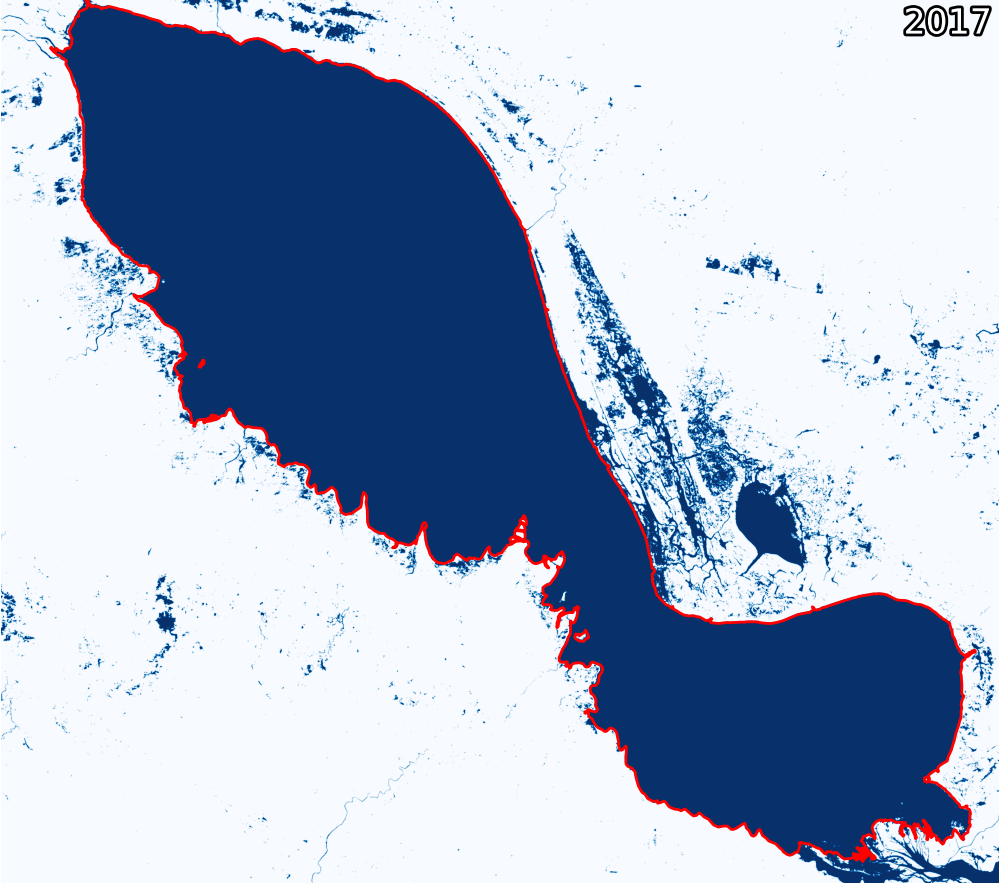

Generating 30 frame animation
    Exporting animation to /g/data/u46/users/ext547/ewater/output_data/wofs/wofs_gm_time_series.gif


In [82]:
animated_timeseries(ds = water_class, output_path='/g/data/u46/users/ext547/ewater/output_data/wofs/wofs_gm_time_series.gif',
                    bands = ['wofs'], show_date= False, onebandplot_cbar=False, x_dim = 'x', 
                    y_dim = 'y', title= water_class.time.dt.year.values.tolist(),shapefile_path = lake_shape,
                    shapefile_kwargs = {'linewidth':2, 'edgecolor':'red', 'facecolor':"#00000000"},
                    onebandplot_kwargs={'cmap':'Blues','vmin':0, 'vmax':1}, interval=1000)

## Calculate and plot WOfS

In [13]:
total_water_obs = water_class.wofs.sum(dim='time')
nbar_count_blue = nbar_clean.blue.count(dim='time')
wofs = ((total_water_obs/nbar_count)*100)

NameError: name 'nbar_count' is not defined

In [31]:
wofs_cmap = mpl.colors.ListedColormap(['white', 'navy'])
wofs_bounds = [0, 1]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)
wofs_norm = mpl.colors.Normalize(vmin=1, vmax=2)

TypeError: float() argument must be a string or a number, not 'list'

In [30]:
#Set up colour ramp details to meet DEA specified colour details
# wofs_cmap = mpl.colors.ListedColormap(['#000000', '#8e0101', '#cf2200', '#e38400',
#                                        '#e3df00', '#a6e300', '#62e300', '#00e32d',
#                                        '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
#                                        '#005fe3', '#000fe3', '#5700e3'])
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                       '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


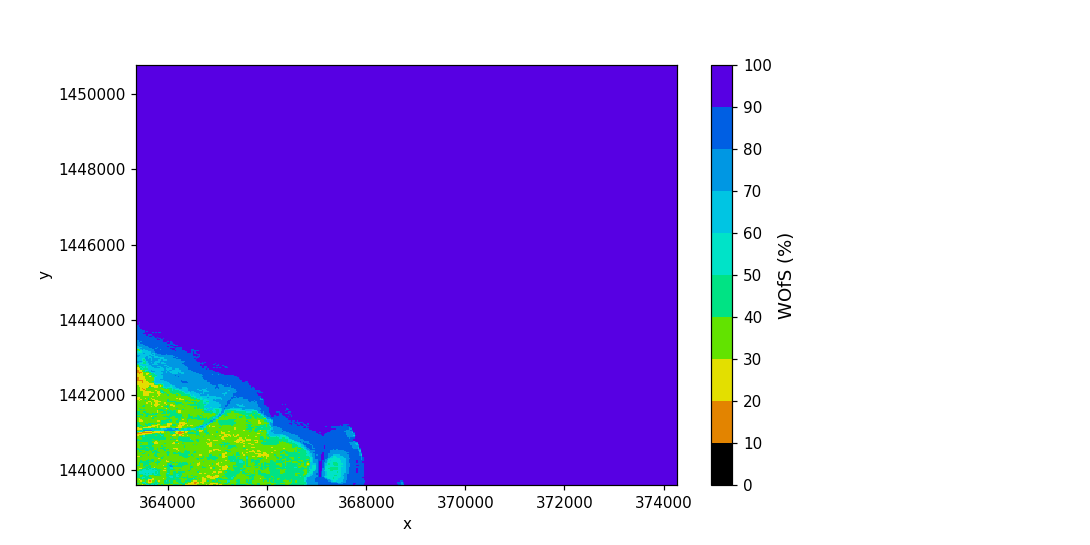

In [31]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='WOfS (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image